<a href="https://colab.research.google.com/github/Nithinps021/DeepLearning/blob/master/hands__on_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import tarfile
from six.moves import urllib

In [25]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH='datasets/housing'
HOUSING_URL=DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path=os.path.join(housing_path,'housing.tgz')
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()
  
fetch_data()


In [27]:
import pandas as pd

def loadHousingData(housing_path=HOUSING_PATH):
  path_housing_csv=os.path.join(housing_path,'housing.csv')
  return pd.read_csv(path_housing_csv)

In [29]:
housingData=loadHousingData()
housingData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [33]:
housingData.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


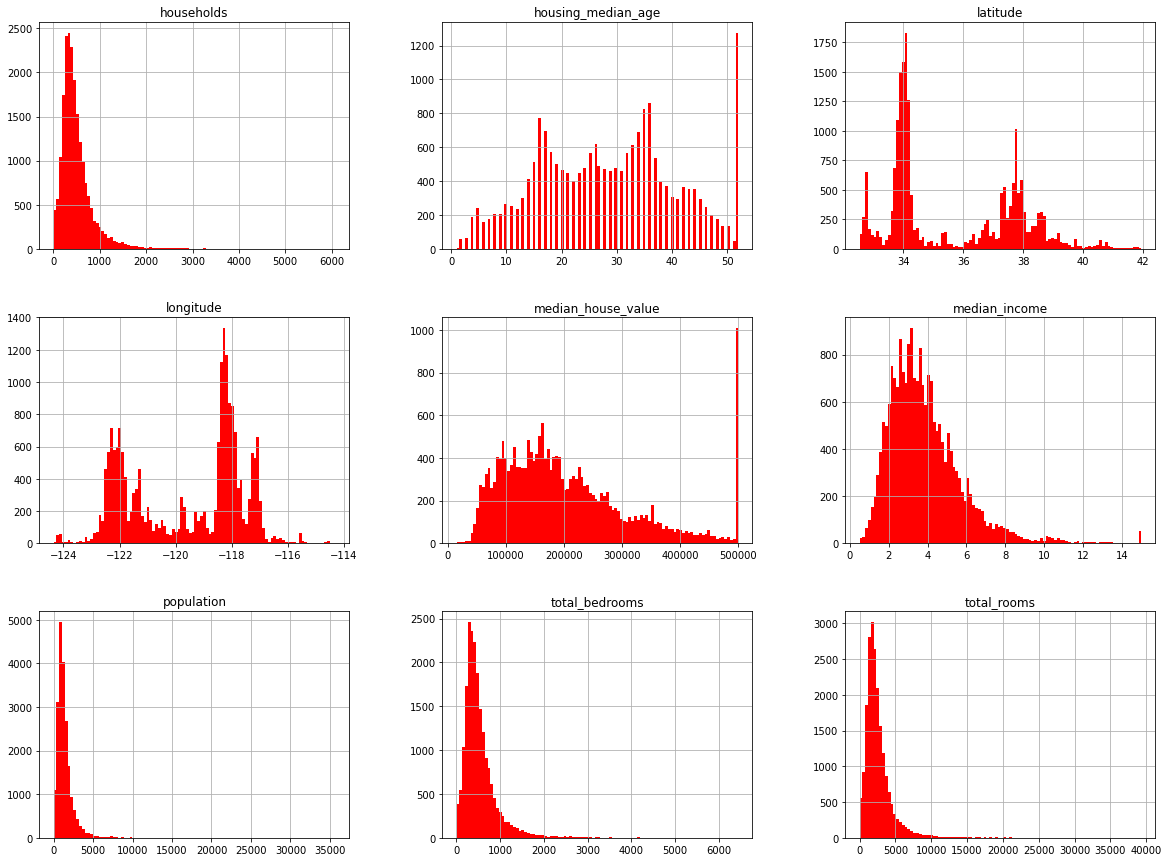

In [43]:
import matplotlib.pyplot as plt

housingData.hist(bins=100,figsize=(20,15),color='red')
plt.show()